In [1]:
import msprime
import numpy as np
import io
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt

set_matplotlib_formats("svg")

/tmp/ipykernel_2310/2451343029.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


(sec_rate_maps)=
# Rate Maps

It is often useful to express a variable rate of some sort along the chromosome.
For example, most organisms have mutation rates and recombination rates which vary
depending on genomic position. Rates of this sort can be stored as an instance
of a {class}`.RateMap`, and then passed as a parameter to the relevant `msprime`
method. For instance, {func}`.sim_ancestry` accepts a {class}`.RateMap`
for the {ref}`recombination_rate<sec_ancestry_recombination>`
parameter and {func}`.sim_mutations` accepts a {class}`.RateMap`
for the {ref}`rate<sec_mutations_rate>` parameter.

A rate map is defined as a set of constant rates which apply piecewise
over contiguous regions of the genome.
For example, here we create a simple rate map over a 30kb genome:

In [2]:
rate_map = msprime.RateMap(
    position=[0, 4000, 9000, 11000, 20000, 30000],
    rate=[0, 0.1, 0.6, 0.2, 0.1]
)
rate_map

left,right,mid,span,rate
0,4000,2000,4000,0
4000,9000,6500,5000,0.1
9000,11000,10000,2000,0.6
11000,20000,15500,9000,0.2
20000,30000,25000,10000,0.1


See the {ref}`sec_rate_maps_basics` section for details on these columns.
We can see how these rates vary along the genome by plotting:

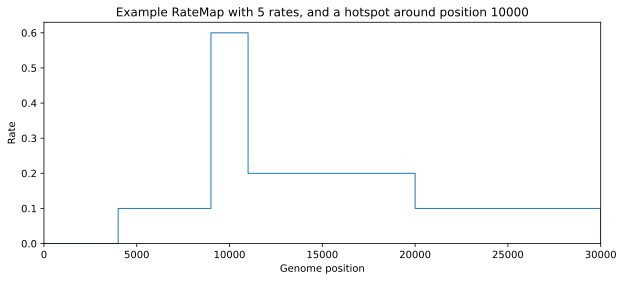

In [3]:
plt.figure(figsize=(10, 4))
plt.stairs(rate_map.rate, rate_map.position)
plt.title("Example RateMap with 5 rates, and a hotspot around position 10000")
plt.xlabel("Genome position")
plt.ylabel("Rate")
plt.xlim(0, rate_map.sequence_length)
plt.show()

---

(sec_rate_maps_quickref)=

## Quick reference

{class}`.RateMap`
: Represent the varying rate of processes along the genome as a piecewise function.

**Creating rate maps**

{meth}`.RateMap.uniform`
: Create a RateMap with a single rate over the entire chromosome

{meth}`.RateMap.read_hapmap`
: Read in a RateMap from a file in "HapMap" format (common in recombination maps)

{meth}`.RateMap.slice`
: Create a new RateMap by slicing out a portion of an existing RateMap

**Computing rates**

{attr}`.RateMap.mean_rate`
: The weighted average rate

{attr}`.RateMap.total_mass`
: The cumulative sum of rates over the entire map

{meth}`.RateMap.get_rate`
: Compute rate at a set of positions

{meth}`.RateMap.get_cumulative_mass`
: Compute the cumulative rate at a set of positions


(sec_rate_maps_basics)=
## Working with RateMaps

In this section we illustrate the ways in which we can interact
with a {class}`.RateMap` object. Throughout we'll use the example
map from the introduction, defined over a 30kb genome:

In [4]:
rate_map = msprime.RateMap(
    position=[0, 4000, 9000, 11000, 20000, 30000],
    rate=[0, 0.1, 0.6, 0.2, 0.1]
)
rate_map

left,right,mid,span,rate
0,4000,2000,4000,0
4000,9000,6500,5000,0.1
9000,11000,10000,2000,0.6
11000,20000,15500,9000,0.2
20000,30000,25000,10000,0.1


:::{seealso}
See the {ref}`sec_rate_maps_creating` section for different ways of
creating {class}`.RateMap` instances with various properties.
:::

To create the {class}`.RateMap` instance we called the constructor
with two lists, ``position`` and ``rate``. These define the
intervals along the genome and the rates in each interval. Because
we are interested in nonoverlapping contiguous intervals, we can
define all the {math}`n` intervals with {math}`n + 1` positions
and corresponding {math}`n` rate values.

:::{important}
All intervals are **open-closed**; that is, the left coordinate
is inclusive and the right coordinate exclusive.
:::

Information about each of the intervals is shown in the summary
table above, one interval per row. So, the last interval has a
``left`` coordinate of 20000, a ``right`` coordinate of 30000,
a midpoint of 25000 (``mid``), has a ``span`` of 10000 base pairs
and maps to a rate of 0.1.

:::{seealso}
See the {ref}`sec_rate_maps_basics_array` for examples of how to
access the columns efficiently as numpy arrays.
:::

(sec_rate_maps_basics_mapping)=
### Mapping interface

The easiest way to access the rate information from a rate map is
via the *mapping interface*. We can use the Python square bracket
notation to get the rate at a particular point:

In [5]:
print("rate at position 4500 = ", rate_map[4500])

rate at position 4500 =  0.1


:::{seealso}
The {meth}`.RateMap.get_rate` method is a more efficient way to
compute the rate values at an array of locations along the genome.
:::

We can also iterate over the intervals in the map, much
as if it was a Python dictionary:

In [6]:
for midpoint, rate in rate_map.items():
    print(midpoint, rate, sep="\t")

2000.0	0.0
6500.0	0.1
10000.0	0.6
15500.0	0.2
25000.0	0.1


Note that the key here is the **midpoint** of each interval.

Operations such as ``in`` tell us whether the a give position is
in the rate map:

In [7]:
print("Is position 10000 in the map?", 10000 in rate_map)
print("Is position -1 in the map?", -1 in rate_map)

Is position 10000 in the map? True
Is position -1 in the map? False


:::{seealso}
See the {ref}`sec_rate_maps_missing` section for information on
how missing data is handled using this interface.
:::


(sec_rate_maps_basics_array)=
### Array interface

We can also access the information from the rate map using numpy
arrays. This is usually the preferred option when working with
rate maps, since they can be quite large.

In [8]:
print("interval left position :", rate_map.left)
print("interval right position:", rate_map.right)
print("interval midpoint      :", rate_map.mid)
print("interval span          :", rate_map.span)
print("interval rate          :", rate_map.rate)

interval left position : [    0.  4000.  9000. 11000. 20000.]
interval right position: [ 4000.  9000. 11000. 20000. 30000.]
interval midpoint      : [ 2000.  6500. 10000. 15500. 25000.]
interval span          : [ 4000.  5000.  2000.  9000. 10000.]
interval rate          : [0.  0.1 0.6 0.2 0.1]


Please see the documentation for
{attr}`~.RateMap.left`,
{attr}`~.RateMap.right`,
{attr}`~.RateMap.mid`,
{attr}`~.RateMap.span`,
and {attr}`~.RateMap.rate` for more information.

The {attr}`~.RateMap.position` array is also defined, which is
equal to the ``left`` array with last element of the ``right``
array (i.e., the {attr}`~.RateMap.sequence_length`) appended to
it.


:::{seealso}
See the {ref}`sec_rate_maps_missing` section for information on
how missing data is handled using this interface.
:::

:::{todo}
Give an example of how we might do something useful with these
arrays, like plotting something, e.g.
:::

(sec_rate_maps_creating)=
## Creating rate maps

A rate map can be created by initializing an instance of the {class}`.RateMap` class
with a list of _n+1_ positions and _n_ rates. Alternatively, uniform rate maps can be
created as described below, or rates read in from a text file. The last position of a
rate map is taken as the sequence length: it is your responsibility to ensure that this
is the same length as the simulated chromosome to which the rate is applied.

(sec_rate_maps_creating_uniform)=
### Uniform rate maps

The most basic rate map is a uniform rate over the entire sequence. This can simply be
generated by {meth}`.RateMap.uniform`:

In [9]:
msprime.RateMap.uniform(sequence_length=1e8, rate=0.5)

left,right,mid,span,rate
0,100000000,50000000,100000000,0.5


(sec_rate_maps_discrete_coordinates)=
### Discrete coordinates

The coordinates in {attr}`.RateMap.position` are floating-point values,
and so are essentially continuous.
However, by default msprime places mutations and recombination breakpoints
at discrete (i.e., integer-valued) coordinates.
When applying a continuous RateMap to a discrete simulation,
msprime follows the philosophy that the rates apply to those integers that fall
within the corresponding intervals.
In other words, `rate[j]` will apply to all *integers* between `position[j]` (inclusive)
and `position[j+1]` (exclusive), i.e., to the integers `ceiling(position[j])`,
`ceiling(position[j]) + 1`, ..., `ceiling(position[j+1}) - 1`.

Concretely, if the positions in a mutation RateMap are `[0., 2.3, 6.7, 10.]`
and the rates are `[0., 2.1, 0.]`, then (in a discrete simulation),
mutations will occur only at positions `3.`, `4.`, and `5.`
(at rate 2.1 each per unit time).

If the same RateMap is used for recombination, we will have breakpoints only at
`3.`, `4.`, and `5.`. However, recall that a recombination breakpoint indicates
the *start* of a new segment of genome, so that a breakpoint at `3.` indicates
(in a discrete simulation) a recombination in the *link* between `2.` and `3.`,
e.g., distinct ancestries on the segments `[0., 1., 2.]` and `[3., 4., ...]`.
This has the consequence that to control the rate of recombination events on the links
`x:(x+1)`, `(x+1):(x+2)`, ... `(y-1):y`, one needs to set the rate
on the interval `[x+1, y)`.


(sec_rate_maps_creating_hotspots)=
### Hotspots

For instance, if we want a recombination RateMap over a chromosome of 10,000bp
with a background rate of `1e-8`,
but a "hotspot" with recombination rate of `1e-5` between positions `4999`
and `5000`, then we would do:

In [10]:
rates = msprime.RateMap(
    position=[0., 5000, 5001, 10000],
    rate=[1e-8, 1e-5, 1e-8]
)

(Note that, as discussed above, the `position` attributes need to be
one more than what one might think based on the verbal description.)

Used for a mutation rate, this would produce a hotspot of mutations
at position `4999`.

### Reading from a text file

Recombination maps are commonly distributed in HapMap format,
as detailed in the documentation for {meth}`.RateMap.read_hapmap`.
Here is a short example
(the code works as if the given text was in a file):

In [11]:
data = io.StringIO("""\
Chromosome  Position(bp)  Rate(cM/Mb)  Map(cM)
chr10       48232         0.1614       0.002664
chr10       48486         0.1589       0.002705
chr10       50009         0.159        0.002947
chr10       52147         0.1574       0.003287
""")
rate_map = msprime.RateMap.read_hapmap(data)
print(rate_map)


┌───────────────────────────────────────────┐
│left   │right  │      mid│   span│     rate│
├───────────────────────────────────────────┤
│0      │48232  │    24116│  48232│  5.5e-10│
│48232  │48486  │    48359│    254│  1.6e-09│
│48486  │50009  │  49247.5│   1523│  1.6e-09│
│50009  │52147  │    51078│   2138│  1.6e-09│
└───────────────────────────────────────────┘



(sec_rate_maps_missing)=

## Missing data

There are often times when we do not know what the rate of a particular
process is along the genome. For example, in telomeric regions, we don't
really know what the rate of recombination is, and we need some way
of encoding this information.

:::{seealso}
See the {ref}`sec_ancestry_missing_data` section for an example
of running an ancestry simulation with unknown recombination rates,
and the properties of the resulting tree sequence.
:::

Following the standard convention in Python numerical libraries,
we encode missing data using [NaN values](https://en.wikipedia.org/wiki/NaN).
Here, for example we create a rate map in which we have a
uniform rate except for the 10 base pairs at either end,
which are unknown:

In [12]:
rate_map = msprime.RateMap(position=[0, 10, 90, 100], rate=[np.nan, 0.1, np.nan])
rate_map

left,right,mid,span,rate
0,10,5,10,nan
10,90,50,80,0.1
90,100,95,10,nan


Values that we compute such as {attr}`~.RateMap.mean_rate` correctly ignore
the regions of missing data:

In [13]:
print("mean rate = ", rate_map.mean_rate)

mean rate =  0.1


The {ref}`sec_rate_maps_basics_mapping` and {ref}`sec_rate_maps_basics_array` have
different semantics for dealing with missing data: the mapping interface
filters out intervals that are missing, whereas the array interface
leaves them in.

### Array interface

The array interface in the {class}`.RateMap` is an efficient way of directly
accessing the underlying array data. To give the user the maximum flexibility,
the per-interval arrays like {attr}`~.RateMap.left` are always defined
over both missing **and** non-missing intervals:

In [14]:
print("left  = ", rate_map.left)
print("right = ", rate_map.right)
print("mid   = ", rate_map.mid)
print("span  = ", rate_map.span)

left  =  [ 0. 10. 90.]
right =  [ 10.  90. 100.]
mid   =  [ 5. 50. 95.]
span  =  [10. 80. 10.]


We can use the {attr}`~.RateMap.missing` and {attr}`~.RateMap.non_missing`
arrays to get access to the missing and non-missing portions of the map.
These are numpy boolean arrays, which we can use to index into the other
per-interval arrays. For example, we can compare the total span of
missing and non-missing intervals:

In [15]:
print("Total missing span      = ", np.sum(rate_map.span[rate_map.missing]))
print("Total non-missing span  = ", np.sum(rate_map.span[rate_map.non_missing]))

Total missing span      =  20.0
Total non-missing span  =  80.0


### Mapping interace

The {ref}`sec_rate_maps_basics_mapping` takes the opposite
approach to missing data to the {ref}`sec_rate_maps_basics_array`: missing
intervals are automatically **filtered** out. Consider what we get when
we iterate over the ``items()`` in the map:

In [16]:
for key, value in rate_map.items():
    print(f"{key} -> {value}")

50.0 -> 0.1


As far as the mapping interface is concerned, we have **one** interval
in this map, **not three**. This logic is reflected by the ``in`` operation:
we only consider a position to be "in" the map if it's in a non-missing
interval:

In [17]:
print("Is position 5 in the map? ", 5 in rate_map)
print("Is position 50 in the map? ", 50 in rate_map)

Is position 5 in the map?  False
Is position 50 in the map?  True


An important consequence of this definition is that the ``len()`` of a
{class}`.RateMap` is the **number of non-empty intervals**:

In [18]:
print("len                       = ", len(rate_map))
print("num_intervals             = ", rate_map.num_intervals)
print("num_non_missing_intervals = ", rate_map.num_non_missing_intervals)

len                       =  1
num_intervals             =  3
num_non_missing_intervals =  1


:::{important}
Because the ``len()`` of a RateMap is defined as the number of
non-empty intervals we recommend using the {attr}`~.RateMap.num_intervals`
and {attr}`~.RateMap.num_non_missing_intervals` for clarity.
:::

(sec_rate_maps_masking_and_slicing)=
### Slicing

Sometimes we are interested in running a simulation for a small portion
of a map, for example when we want to focus on a small region of a much
larger chromosome. We can do this using the
{meth}`~.RateMap.slice` method, which extracts a target region from a
given map and marks the flanking regions as {ref}`missing data<sec_rate_maps_missing>`,
so that the original coordinate system is maintained.

:::{todo}
Example of the slice method and slice notation on small maps
so we can illustrate them.
:::

#### Simulation example

For example, if you wish to simulate a 40 kb section of human chromosome
1 from position 0.7Mb, but keep the standard chromosome 1 genomic coordinates, you could
do this:

In [19]:
import io
# First and last sections of human chr 1 build 36 genetic map taken from
# https://ftp.ncbi.nlm.nih.gov/hapmap/recombination/latest/rates/
hapmap_chr1_snippet = io.StringIO("""\
chr position COMBINED_rate(cM/Mb) Genetic_Map(cM)
1 72434 0.0015000000 0
1 78032 0.0015000000 0.0000083970
1 554461 0.0015000000 0.0007230405
1 554484 0.0015000000 0.0007230750
1 555296 0.0015000000 0.0007242930
1 558185 0.0015000000 0.0007286265
1 558390 0.0010000000 0.0007289340
1 711153 1.9757156611 0.0008816970
1 713682 2.0415081787 0.0058782819
1 713754 2.1264889217 0.0060252705
1 718105 2.1260252999 0.0152776238
1 719811 2.1911540342 0.0189046230
1 728873 2.1938678585 0.0387608608
1 730720 2.1951341342 0.0428129347
1 740098 1.3377804252 0.0633989027
1 742429 0.9035885389 0.0665172688
1 743132 0.9037201735 0.0671524916  # Next 256440 lines snipped
1 247184904 0.6238867396 278.0908415443
1 247185273 0 278.0910717585""")
large_ratemap = msprime.RateMap.read_hapmap(hapmap_chr1_snippet)
sliced_ratemap = large_ratemap.slice(700e3, 740e3)
ts = msprime.sim_ancestry(10, recombination_rate=sliced_ratemap, random_seed=1)

Because the recombination rate is marked as unknown in regions below
position 700 000 and above position
740 000, `msprime` has not had to put effort into simulating recombination (and its
effect on ancestry) in these regions, so the simulation completes very quickly, even
though the resulting tree sequence has a `sequence_length` of 247 megabases.

:::{seealso}
See the {ref}`sec_ancestry_missing_data` section for more information
about how ancestry simulations with missing rate data are performed.
:::